In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from qiskit import transpile
from qiskit.circuit.library import real_amplitudes as RealAmplitudes
from qiskit_aer.primitives import SamplerV2

# 사용자 정의 모듈 임포트
from src.noise_models import build_custom_noise_model
from src.qcluster import QClusterMitigator
from src.visualization import plot_mitigation_result, plot_pca_clusters

print("Libraries imported successfully!")

Libraries imported successfully!


Circuit created with 5 qubits.


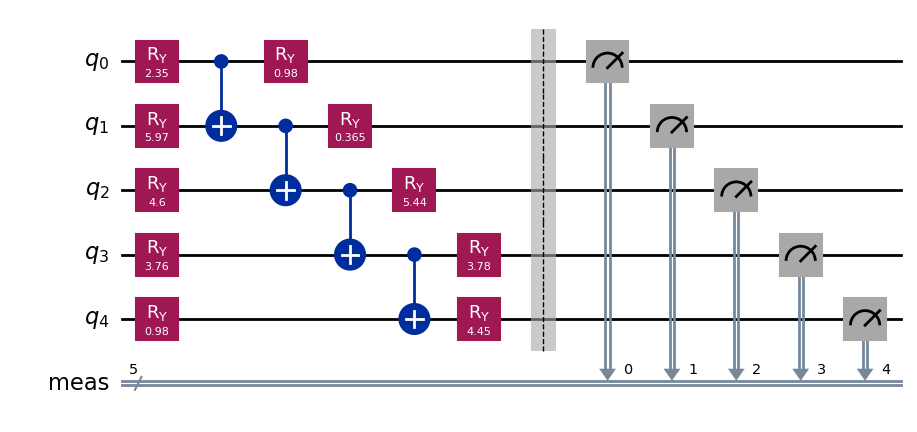

In [3]:
# 1. 하이퍼파라미터 설정
n_qubits = 5
n_shots = 2048
np.random.seed(42)

# 2. Ansatz 회로 생성 (RealAmplitudes)
ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1, entanglement='linear')
ansatz.measure_all()

# 3. 파라미터 바인딩 (Random but fixed)
fixed_params = np.random.rand(ansatz.num_parameters) * 2 * np.pi
qc = ansatz.assign_parameters(fixed_params)

# 4. Transpile
qc_transpiled = transpile(qc, optimization_level=0)
print(f"Circuit created with {n_qubits} qubits.")
qc.draw('mpl')

In [4]:
# [Ideal Simulation] 노이즈 없는 이상적인 결과
sampler_ideal = SamplerV2()
job_ideal = sampler_ideal.run([qc_transpiled], shots=n_shots)
counts_ideal = job_ideal.result()[0].data.meas.get_counts()

# [Noisy Simulation] Readout Error가 심한 환경 조성
# p_readout=0.10 (10% 확률로 비트 반전)
noise_model = build_custom_noise_model(p_depol=0.01, p_readout=0.10)

sampler_noisy = SamplerV2()
sampler_noisy.options.simulator = {"noise_model": noise_model}

job_noisy = sampler_noisy.run([qc_transpiled], shots=n_shots)
pub_result = job_noisy.result()[0]

# 데이터 추출
bitstrings_noisy = pub_result.data.meas.get_bitstrings()
counts_noisy = pub_result.data.meas.get_counts()

print(f"Collected {len(bitstrings_noisy)} noisy shots.")
print(f"Top 5 Noisy Counts: {dict(list(counts_noisy.items())[:5])}...")

Collected 2048 noisy shots.
Top 5 Noisy Counts: {'01111': 179, '01011': 437, '01010': 241, '00011': 335, '01110': 114}...


In [5]:
# Q-Cluster 모델 초기화 (Cluster 개수 k는 튜닝 파라미터)
k_clusters = 6
mitigator = QClusterMitigator(k_clusters=k_clusters, max_iters=15)

# 학습 (Fit)
print("Running Q-Cluster algorithm...")
mitigator.fit(bitstrings_noisy)

# 완화 (Mitigate)
counts_mitigated = mitigator.mitigate(bitstrings_noisy)
centroids = mitigator.get_centroids()

print(f"Converged Centroids: {centroids}")
print("Mitigation Complete.")

Running Q-Cluster algorithm...
Converged Centroids: [np.str_('01010'), np.str_('00011'), np.str_('01011'), np.str_('01011'), np.str_('00010'), np.str_('01010')]
Mitigation Complete.


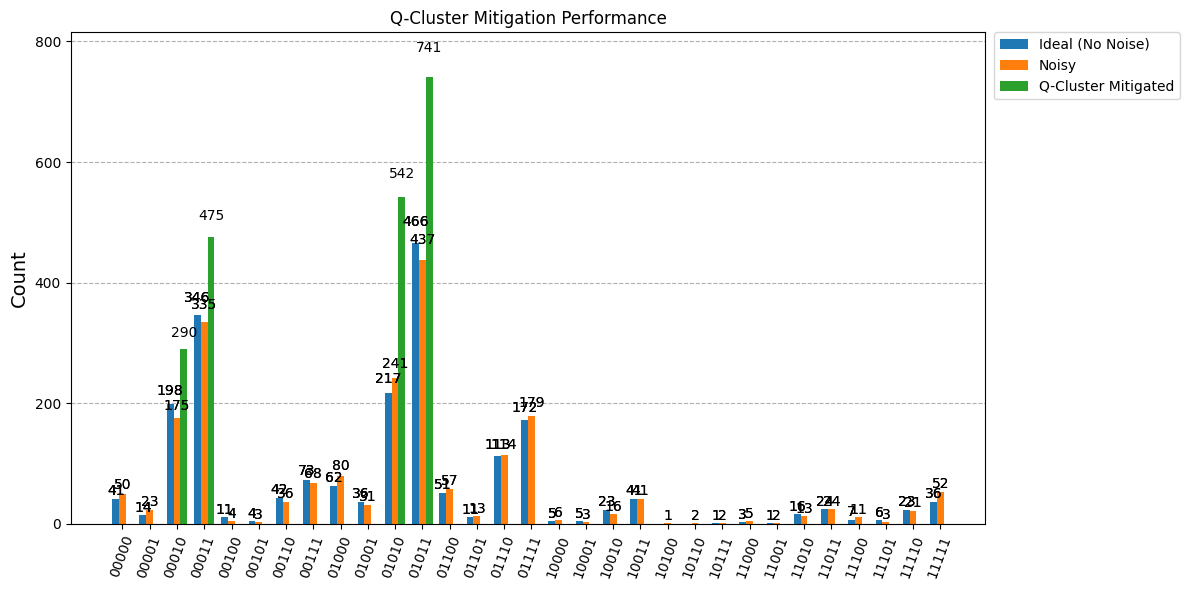

In [6]:
# Histogram 비교 시각화
plot_mitigation_result(counts_ideal, counts_noisy, counts_mitigated)

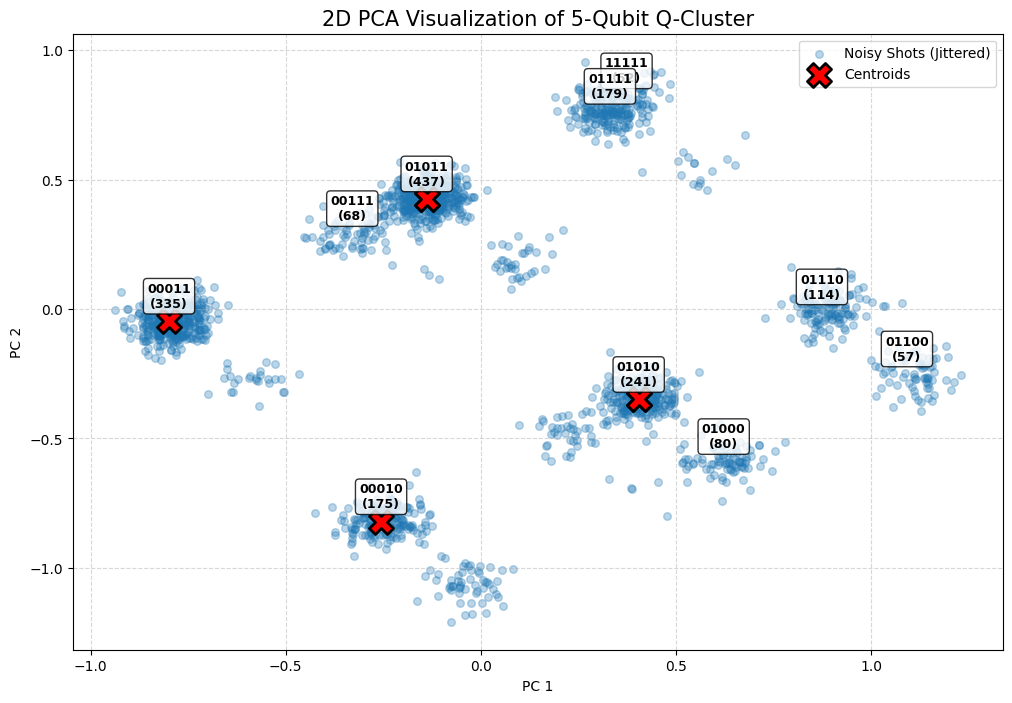

In [7]:
# PCA를 이용한 2D 시각화
plot_pca_clusters(bitstrings_noisy, centroids, counts_noisy, n_qubits)